In [ ]:
# Step 1: Import Libraries
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json here

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"prashantbhardwaj193","key":"706167b953e601e7f4591d4547fb4812"}'}

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# Step 2: Download Dataset from Kaggle (Ensure kaggle.json is configured in ~/.kaggle/)
!kaggle datasets download -d rijulshr/pneumoniamnist

Dataset URL: https://www.kaggle.com/datasets/rijulshr/pneumoniamnist
License(s): MIT
pneumoniamnist.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/pneumoniamnist.zip

Archive:  /content/pneumoniamnist.zip
replace pneumoniamnist.npz? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: pneumoniamnist.npz      


In [ ]:
# Load data from NPZ file
data = np.load('/content/pneumoniamnist.npz')

In [ ]:
# Extract datasets
train_images = data['train_images']
train_labels = data['train_labels']
val_images = data['val_images']
val_labels = data['val_labels']
test_images = data['test_images']
test_labels = data['test_labels']

In [ ]:
# Close the NPZ file
data.close()

In [ ]:
# First, check and manage Colab resources
!nvidia-smi  # Check GPU memory
!free -h  # Check system memory

Mon Jul  7 07:25:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Configure TensorFlow to use memory more efficiently
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except:
        pass

In [ ]:
# %%
# Optimized data loading function
def load_data_npz(file_path, sample_limit=None):
    data = np.load(file_path)

    # Load data in chunks if sample_limit is specified
    if sample_limit:
        train_images = data['train_images'][:sample_limit]
        train_labels = data['train_labels'][:sample_limit]
        val_images = data['val_images'][:sample_limit//5] if sample_limit//5 > 0 else data['val_images']
        val_labels = data['val_labels'][:sample_limit//5] if sample_limit//5 > 0 else data['val_labels']
        test_images = data['test_images'][:sample_limit//5] if sample_limit//5 > 0 else data['test_images']
        test_labels = data['test_labels'][:sample_limit//5] if sample_limit//5 > 0 else data['test_labels']
    else:
        train_images = data['train_images']
        train_labels = data['train_labels']
        val_images = data['val_images']
        val_labels = data['val_labels']
        test_images = data['test_images']
        test_labels = data['test_labels']

    data.close()
    return train_images, train_labels, val_images, val_labels, test_images, test_labels


In [ ]:
# Load data with optional sample limit (reduce if crashes persist)
train_images, train_labels, val_images, val_labels, test_images, test_labels = load_data_npz(
    '/content/pneumoniamnist.npz',
    sample_limit=4000  # Reduce this number if crashes occur
)

In [ ]:
# %%
# Memory-efficient preprocessing
def preprocess_batch(images, labels):
    # Convert to 3-channel in batches
    images_batch = np.stack([images]*3, axis=-1)
    # Resize
    images_batch = tf.image.resize(images_batch, [299, 299]).numpy()
    # Normalize
    images_batch = images_batch.astype('float32') / 255.0
    return images_batch, labels.flatten()

# Process data in smaller batches
batch_size = 1000
processed_data = []
for i in range(0, len(train_images), batch_size):
    batch = preprocess_batch(
        train_images[i:i+batch_size],
        train_labels[i:i+batch_size]
    )
    processed_data.append(batch)

train_images, train_labels = zip(*processed_data)
train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)

In [ ]:
# Process validation and test sets
val_images, val_labels = preprocess_batch(val_images, val_labels)
test_images, test_labels = preprocess_batch(test_images, test_labels)

# Clear unused variables to free memory
del processed_data
import gc
gc.collect()

9

In [ ]:
# %%
# Memory-efficient data generator
class MemorySafeDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, batch_size=32, augment=False):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.augment = augment
        self.datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest'
        ) if augment else None

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.images[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_labels = self.labels[idx*self.batch_size:(idx+1)*self.batch_size]

        if self.augment:
            batch_images = next(self.datagen.flow(
                batch_images,
                batch_labels,
                batch_size=len(batch_images),
                shuffle=False
            ))[0]

        return batch_images, batch_labels

In [ ]:
# Create generators
train_gen = MemorySafeDataGenerator(train_images, train_labels, augment=True)
val_gen = MemorySafeDataGenerator(val_images, val_labels)
test_gen = MemorySafeDataGenerator(test_images, test_labels)

In [ ]:
# %%
# Lightweight model architecture
def create_light_inceptionv3():
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(299, 299, 3),
        pooling='avg'
    )

    # Freeze most layers
    for layer in base_model.layers[:150]:
        layer.trainable = False

    # Simplified head
    x = base_model.output
    x = Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

model = create_light_inceptionv3()
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,933,985 (83.67 MB)

 Trainable params: 17,498,177 (66.75 MB)

 Non-trainable params: 4,435,808 (16.92 MB)

In [ ]:
# %%
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [ ]:
# %%
# Compile model with class weights
class_weights = {0: 1., 1: len(train_labels[train_labels==0])/len(train_labels[train_labels==1])}

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Callbacks
callbacks = [
    ReduceLROnPlateau(factor=0.5, patience=2, verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

In [ ]:
# %%
# Create data generators
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    train_images,
    train_labels,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    val_images,
    val_labels,
    batch_size=32,
    shuffle=False
)


In [ ]:
# %%
# Train model with fixed parameters
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=30,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - accuracy: 0.9685 - auc: 0.9955 - loss: 0.0148 - recall: 0.9672

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9685 - auc: 0.9955 - loss: 0.0148 - recall: 0.9672 - val_accuracy: 0.9523 - val_auc: 0.9675 - val_loss: 0.2908 - val_recall: 0.9949 - learning_rate: 1.0000e-04
Epoch 2/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.9693 - auc: 0.9960 - loss: 0.0147 - recall: 0.9678

122/122 ━━━━━━━━━━━━━━━━━━━━ 101s 827ms/step - accuracy: 0.9693 - auc: 0.9960 - loss: 0.0147 - recall: 0.9678 - val_accuracy: 0.9599 - val_auc: 0.9679 - val_loss: 0.2540 - val_recall: 0.9897 - learning_rate: 1.0000e-04
Epoch 3/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 726ms/step - accuracy: 0.9643 - auc: 0.9937 - loss: 0.0168 - recall: 0.9623

122/122 ━━━━━━━━━━━━━━━━━━━━ 142s 834ms/step - accuracy: 0.9643 - auc: 0.9937 - loss: 0.0168 - recall: 0.9623 - val_accuracy: 0.9771 - val_auc: 0.9894 - val_loss: 0.1209 - val_recall: 0.9794 - learning_rate: 1.0000e-04
Epoch 4/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 92s 747ms/step - accuracy: 0.9679 - auc: 0.9938 - loss: 0.0177 - recall: 0.9671 - val_accuracy: 0.9179 - val_auc: 0.9889 - val_loss: 0.2561 - val_recall: 0.8895 - learning_rate: 1.0000e-04
Epoch 5/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.9707 - auc: 0.9955 - loss: 0.0145 - recall: 0.9693
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
122/122 ━━━━━━━━━━━━━━━━━━━━ 92s 754ms/step - accuracy: 0.9707 - auc: 0.9955 - loss: 0.0145 - recall: 0.9693 - val_accuracy: 0.9580 - val_auc: 0.9952 - val_loss: 0.1361 - val_recall: 0.9434 - learning_rate: 1.0000e-04
Epoch 6/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - accuracy: 0.9765 - auc: 0.9972 - loss: 0.0110 - recall: 0.9742

122/122 ━━━━━━━━━━━━━━━━━━━━ 152s 837ms/step - accuracy: 0.9765 - auc: 0.9972 - loss: 0.0110 - recall: 0.9743 - val_accuracy: 0.9637 - val_auc: 0.9968 - val_loss: 0.0820 - val_recall: 0.9614 - learning_rate: 5.0000e-05
Epoch 7/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 92s 751ms/step - accuracy: 0.9841 - auc: 0.9989 - loss: 0.0068 - recall: 0.9831 - val_accuracy: 0.9714 - val_auc: 0.9938 - val_loss: 0.0828 - val_recall: 0.9692 - learning_rate: 5.0000e-05
Epoch 8/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 725ms/step - accuracy: 0.9782 - auc: 0.9981 - loss: 0.0103 - recall: 0.9771
Epoch 8: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
122/122 ━━━━━━━━━━━━━━━━━━━━ 91s 746ms/step - accuracy: 0.9781 - auc: 0.9981 - loss: 0.0103 - recall: 0.9771 - val_accuracy: 0.9656 - val_auc: 0.9933 - val_loss: 0.0838 - val_recall: 0.9692 - learning_rate: 5.0000e-05
Epoch 9/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 91s 746ms/step - accuracy: 0.9923 - auc: 0.9997 - loss: 0.0043 - recall: 0.9917 - val_accuracy: 0.9

In [ ]:
# %%
# Evaluate model
test_results = model.evaluate(test_images, test_labels, verbose=1)
print(f"\nTest Accuracy: {test_results[1]:.4f}")
print(f"Test AUC: {test_results[2]:.4f}")
print(f"Test Recall: {test_results[3]:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.8903 - auc: 0.9293 - loss: 0.7025 - recall: 0.9958

Test Accuracy: 0.8958
Test AUC: 0.9309
Test Recall: 0.9923


In [ ]:
# Generate predictions
y_pred = model.predict(test_images)
y_pred_classes = (y_pred > 0.5).astype(int)

# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, y_pred_classes, target_names=['Normal', 'Pneumonia']))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(test_labels, y_pred_classes))

20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 455ms/step

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.74      0.84       234
   Pneumonia       0.86      0.99      0.92       390

    accuracy                           0.90       624
   macro avg       0.92      0.86      0.88       624
weighted avg       0.91      0.90      0.89       624


Confusion Matrix:
[[172  62]
 [  3 387]]


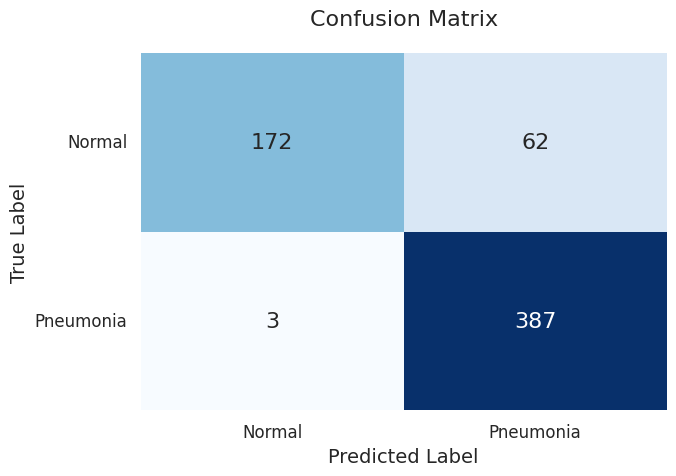

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Your confusion matrix
conf_matrix = np.array([[172, 62],
                       [  3, 387]])

# Class names
class_names = ['Normal', 'Pneumonia']

# Create the plot
plt.figure(figsize=(7, 5))
sns.set(font_scale=1.2)  # Adjust font size
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                 cbar=False, annot_kws={"size": 16})

# Customize the plot
ax.set_title('Confusion Matrix', pad=20, fontsize=16)
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)

# Set tick labels
ax.xaxis.set_ticklabels(class_names, fontsize=12)
ax.yaxis.set_ticklabels(class_names, fontsize=12, rotation=0)

plt.tight_layout()
plt.show()

In [ ]:
# In your model compilation (ensure precision metric is included):
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision')  # This tracks precision for class 1
    ]
)

# For tracking precision per class (add after model training):
from sklearn.metrics import precision_score

# Calculate precision for each class
precision_normal = precision_score(test_labels, y_pred_classes, pos_label=0)
precision_pneumonia = precision_score(test_labels, y_pred_classes, pos_label=1)

print(f"\nDetailed Precision Scores:")
print(f"Normal (Class 0) Precision: {precision_normal:.4f}")
print(f"Pneumonia (Class 1) Precision: {precision_pneumonia:.4f}")
print(f"Macro-average Precision: {(precision_normal + precision_pneumonia)/2:.4f}")


Detailed Precision Scores:
Normal (Class 0) Precision: 0.9829
Pneumonia (Class 1) Precision: 0.8619
Macro-average Precision: 0.9224



ROC AUC: 0.9719


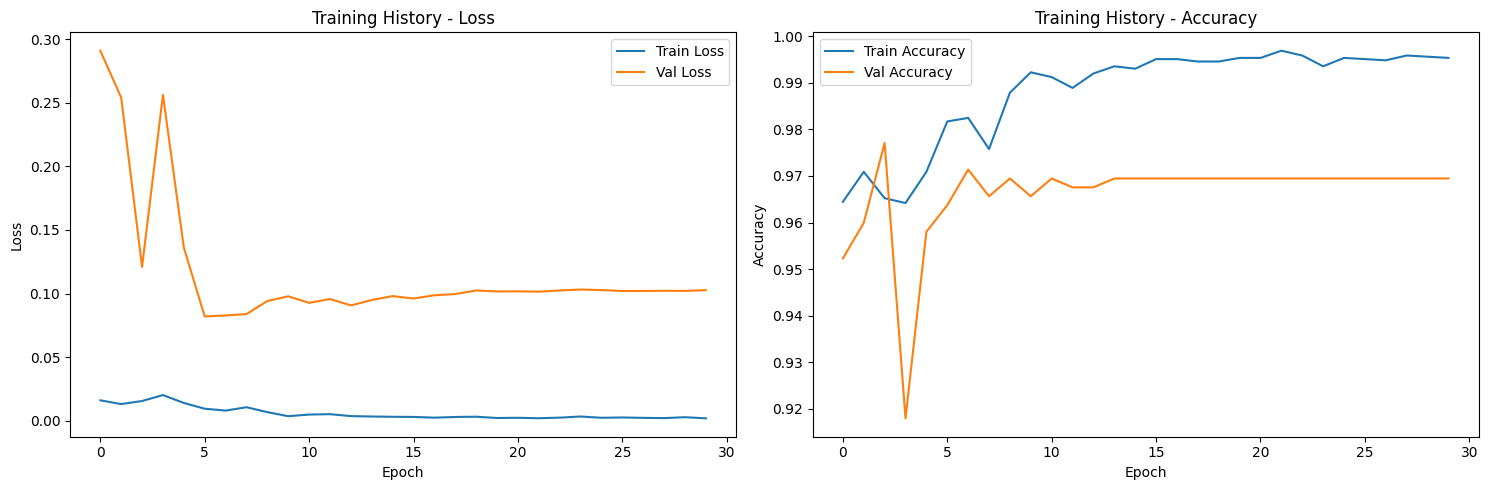

In [ ]:
# ROC AUC
print(f"\nROC AUC: {roc_auc_score(test_labels, y_pred):.4f}")

# %%
# Plot full training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training History - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training History - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


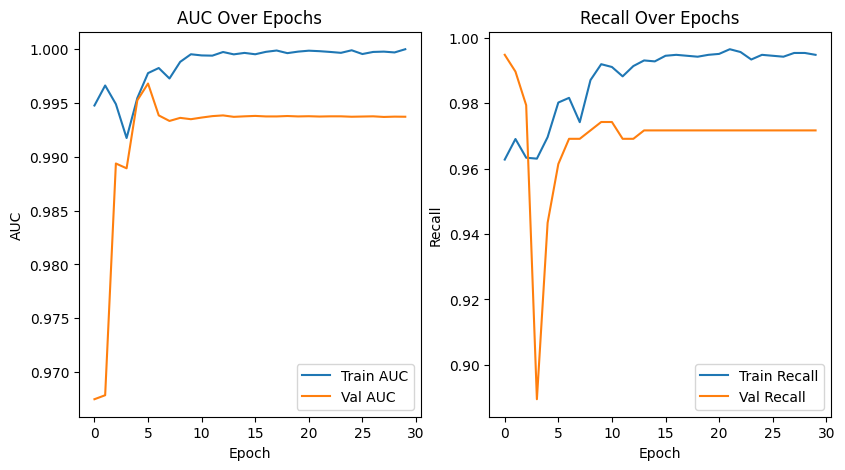

In [ ]:
# %%
# Plot metrics
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall')
plt.title('Recall Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()